In [1]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
from math import sqrt
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
def visualize(a,b,c):
    ax = axes3d.Axes3D(plt.figure())
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = b * np.outer(np.sin(u), np.sin(v))
    z = b * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z,  rstride=4, cstride=4)
    plt.show()
    return 0

In [23]:
### SETTINGS
MAX_COUNT_ITER = 500
EPS = 10**(-5)
DIM = 3
h = np.array([0.001, 0.001, 0.001], dtype = float)

###CONSTRAINTS for ellipsoid x^2/a^2 + y^2/b^2 + z^2/c^2 <= 1
A = 1.0/16 #1.0/16   #actually it's a^2
B = 1.0/4 #0.25   #actually it's b^2
C = 1.0/100 #1.0   #actually it's c^2

### TARGET FUNCTIONS
def f_test(x):
    return 2.0 * x[0] + 3.0 * x[1] + x[2]   
    #return (x[0] - 3) ** 2 + 8 * (x[1] + 1) ** 2 + 2 * (x[0] - 3) * (x[1] + 1) + x[2] ** 2

def f_myvar(x):
    return 2.0 * x[0] + 3.0 * x[1] + x[2]   

f = f_test
x0 = np.array([0, 0, 0], dtype = float)

In [24]:
def df1(f,x,h):
    return (f([x[0] + h, x[1], x[2]]) - f([x[0] - h, x[1], x[2]])) / (2.0 * h)
def df2(f,x,h):
    return (f([x[0], x[1] + h, x[2]]) - f([x[0], x[1] - h, x[2]])) / (2.0 * h)
def df3(f,x,h):
    return (f([x[0], x[1], x[2] + h]) - f([x[0], x[1], x[2] - h])) / (2.0 * h)

def grad(f,x,h):
    return np.array([df1(f,x,h[0]), df2(f,x,h[1]), df3(f,x,h[2])], dtype = float)

def alpha_split(f,x,step,b=1,l=0.5,q=0.1):
    alpha = b
    #while (f(x+alpha*step) >= f(x)):
    while f(x+alpha*step) > f(x) + q * alpha * grad(f,x,h).dot(step):
        alpha *= l
    #print(alpha)
    return alpha

### STOP CONDITIONS
def stop1(x1,x2,k):
    d = norm(x2-x1)
    plt.xlabel('iteration')
    plt.ylabel('|| x_new - x_old || ')
    plt.scatter(k, d)
    return d<=EPS

def stop2(f,x1,x2,k):
    d = abs(f(x2)-f(x1))
    plt.xlabel('iteration')
    plt.ylabel('| f(x_new) - f(x_old) | ')    
    plt.scatter(k, d)
    return d<=EPS

def norm(s):
    return sqrt(s[0]**2 + s[1]**2 + s[2]**2)

def norm2(s):
    return sqrt(A * s[0]**2 + B * s[1]**2 + C * s[2]**2)

###PROJECTIONS
def projection_ellipsoid(point): 
    if (A * point[0]**2 + B * point[1]**2 + C * point[2]**2) <= 1:
        return point
    dist = lambda x: norm2(x - point) #norm(x - point)
    ellipse = ( {'type': 'ineq', 'fun': lambda x: 1 - A * x[0]**2 - B * x[1]**2 - C * x[2]**2}) 
    return minimize(dist, (0.0, 0.0, 0.0), method='SLSQP', constraints = ellipse).x

def projection_ball(point, a = np.zeros((DIM)), r=1):
    prj = a + r * (point - a)*1.0/norm(point - a)
    #nrm = norm(point - a)
    #prj = np.array([a[i] + r * (point[i]-a[i])/nrm for i in range(DIM)])
    #print(point)
    #print(prj)
    return prj

def my_projection_ellipsoid(point):
    if (A * point[0]**2 + B * point[1]**2 + C * point[2]**2) <= 1:
        return point
    #temp = projection_ball(point)
    temp = projection_ball([sqrt(A) * point[0], sqrt(B) * point[1], sqrt(C) * point[2]]) 
    prj = np.array([sqrt(1/A) * temp[0], sqrt(1/B) * temp[1], sqrt(1/C) * temp[2]])
    #print(temp)    
    #print(x_new)     
    #print(norm(temp)) 
    #print(A * prj[0]**2 + B * prj[1]**2 + C * prj[2]**2)
    return prj

def my_projection_ellipsoid_2(point):
    if (A * point[0]**2 + B * point[1]**2 + C * point[2]**2) <= 1:
        return point
    #temp = projection_ball(point)
    #temp = projection_ball([sqrt(A) * point[0], sqrt(B) * point[1], sqrt(C) * point[2]]) 
    #prj = np.array([sqrt(1/A) * temp[0], sqrt(1/B) * temp[1], sqrt(1/C) * temp[2]])
    prj = point / norm2(point)
    return prj

# МПГ З ВИКОРИСТАННЯМ БІБЛІОТЕЧНОЇ ФУНКЦІЇ МІНІМІЗАЦІЇ


Approximate solution found in 5 iterations
> Approximate   x*  = (-1.26255, -1.89356, -0.63122)
> Approximate f(x*) = -8.83698


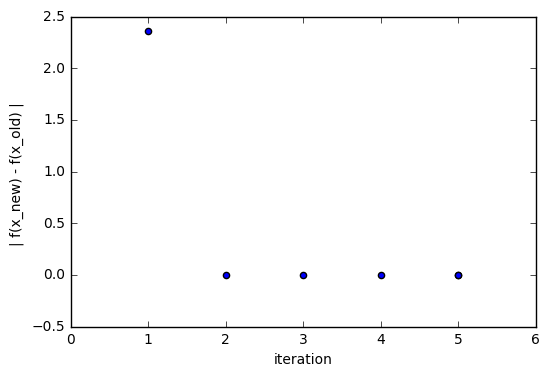

In [25]:
def projection_gradient_method(f,x0,h):
    fout = open('output.txt', 'w')
    fout.write('The initial point is ({}, {}, {})\n\n'.format(*x0))
    x_new = x0
    k = 0
    while (k<MAX_COUNT_ITER):
        k += 1 
        x_old = x_new    
        step = - grad(f,x_old,h)
        alpha = alpha_split(f,x_old,step)
        t = x_old + alpha * step
        fout.write('grad = ({:>4.2f}, {:>4.2f}, {:>4.2f})\n'.format(*step))
        fout.write('{iter:>3}. alpha = {al:<5.3f},   x_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   '.format(iter=k, *t, al=alpha))
        x_new = projection_ellipsoid(t)
        fout.write('prx_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   f(x_{iter:<}) = {f:>7.4f}\n'.format(iter=k, *x_new, f=f(x_new)))
        if (stop1(x_old,x_new,k) and stop2(f,x_old,x_new,k)):
            break
    print('Approximate solution found in {} iterations'.format(k))
    print('> Approximate   x*  = ({:>8.5f}, {:>8.5f}, {:>8.5f})'.format(*x_new))
    print('> Approximate f(x*) = {:>8.5f}'.format(f(x_new)))
    fout.write('\nThe approximate solution of the problem is ({:>8.5f}, {:>8.5f}, {:>8.5f})\n'.format(*x_new))
    fout.write('The value of function in this point is {:>8.5f}\n'.format(f(x_new)))
    fout.close()
    #print(A * x_new[0]**2 + B * x_new[1]**2 + C * x_new[2]**2)
    #print('error = ',abs(f(x_new)+sqrt(41.0/6)))
    return x_new

minim = projection_gradient_method(f,x0,h)
plt.show()
print()

# МПГ З ПРИБЛИЗНОЮ ФОРМУЛОЮ ДЛЯ ОБЧИСЛЕННЯ ПРОЕКЦІЇ

Approximate solution found in 2 iterations
> Approximate   x*  = (-1.26239, -1.89358, -0.63119)
> Approximate f(x*) = -8.83672
1.0


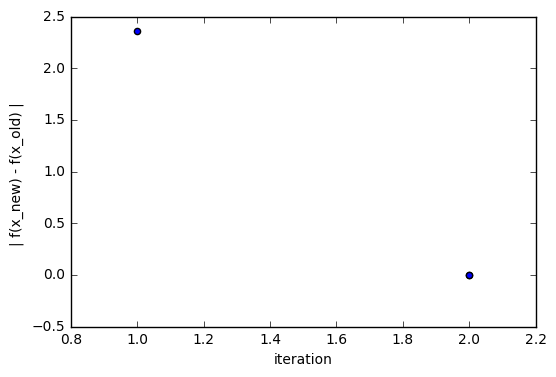

In [26]:
def projection_gradient_method_f(f,x0,h):
    fout = open('output.txt', 'w')
    fout.write('MY. The initial point is ({}, {}, {})\n\n'.format(*x0))
    x_new = x0
    k = 0
    while (k<MAX_COUNT_ITER):
        k += 1 
        x_old = x_new    
        step = - grad(f,x_old,h)
        alpha = alpha_split(f,x_old,step)
        t = x_old + alpha * step
        fout.write('grad = ({:>4.2f}, {:>4.2f}, {:>4.2f})\n'.format(*step))
        fout.write('{iter:>3}. alpha = {al:<5.3f},   x_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   '.format(iter=k, *t, al=alpha))
        fout.write('norm = ' + str(A * t[0]**2 + B * t[1]**2 + C * t[2]**2) + '\n')
        x_new = my_projection_ellipsoid(t)
        fout.write('prx_{iter:<3} = ({:>7.4f}, {:>7.4f}, {:>7.4f}),   f(x_{iter:<}) = {f:>7.4f}\n'.format(iter=k, *x_new, f=f(x_new)))
        if (stop1(x_old,x_new,k) and stop2(f,x_old,x_new,k)):
            break
    
    print('Approximate solution found in {} iterations'.format(k))
    print('> Approximate   x*  = ({:>8.5f}, {:>8.5f}, {:>8.5f})'.format(*x_new))
    print('> Approximate f(x*) = {:>8.5f}'.format(f(x_new)))
    fout.write('\nThe approximate solution of the problem is ({:>8.5f}, {:>8.5f}, {:>8.5f})\n'.format(*x_new))
    fout.write('The value of function in this point is {:>8.5f}\n'.format(f(x_new)))
    fout.close()
    print(A * x_new[0]**2 + B * x_new[1]**2 + C * x_new[2]**2)
    #print('error = ',abs(f(x_new)+sqrt(41.0/6)))
    return x_new

minim = projection_gradient_method_f(f,x0,h)
plt.show()
print()